In [ ]:
# ax = plt.subplot(111, frame_on=False)
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# table(ax, ldfc.head(5))
# write_table(ldfc.head(5), 'test')

In [8]:
# ldfcgt = ldfcg[ldfcg['Order'] <= 10]
# ldfngt = ldfng[ldfng['Order'] <= 10]
# err_n = err_n.reset_index()
# err_n = np.array(err_n[err_n.index<10].drop('Order', axis=1))
# err_c = err_c.reset_index()
# err_c = np.array(err_c[err_c.index<10].drop('Order', axis=1))
# plt.figure(10)
# sns.scatterplot(ldfcgt['Concentration'], ldfcgt['Order'], label='Constricted (case 6)')
# plt.errorbar(ldfcgt['Concentration'], ldfcgt['Order'], xerr=err_c, fmt=None, label=None)
# sns.scatterplot(ldfngt['Concentration'], ldfngt['Order'], label='Normal')
# plt.errorbar(ldfngt['Concentration'], ldfngt['Order'], xerr=err_n, fmt=None, label=None) 
# plt.legend(loc='upper left')
# plt.savefig('asym_end_insp_conc_order_below_10_grouped_case_6.png')

In [1]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from pandas.tools.plotting import table
mpl.rcParams['figure.figsize'] = [16.0, 9.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

In [2]:
import docx
def write_table(df, file_name):
    
    # open an existing document
    doc = docx.Document()

    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    # extra column is for the index
    t = doc.add_table(df.shape[0]+1, df.shape[1]+1)

    t.cell(0, 0).text = df.index.name
    # add the index
    for c, j in enumerate(df.index):
        t.cell(c+1, 0).text = str(j)
        
    # add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0, j+1).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1, j+1).text = str(np.round(df.values[i,j], 3))

    # save the doc
    doc.save(file_name + '.docx')

In [3]:
def read_file_data(file_name, geom_path):
    nodes = []
    data = []
    x = []
    y = []
    z = []
    with open(file_name, 'r') as f:
        for line in f:
            if 'Node' in line:
                n = line.split()
                nodes.append(int(n[1]))
                line2 = f.readline()
                data.append(float(line2.split()[0]))
    with open(geom_path + '/nodes.txt') as f:
        for line in f:
            if 'Node' in line:
                line2 = f.readline()
                x.append(float(line2.split()[0]))
                line2 = f.readline()
                y.append(float(line2.split()[0]))
                line2 = f.readline()
                z.append(float(line2.split()[0]))
    path_length = [0]
    with open(geom_path + '/path_length.txt') as f:
        for line in f:
            path_length.append(float(line.split()[1]))
    node_df = pd.DataFrame({'Node numbers': nodes,
                        'Concentration': data,
                        'Path_length' : path_length,
                        'x': x,
                        'y': y,
                        'z': z})
    node_df['% Height'] = (node_df['z'] - node_df['z'].min())/(node_df['z'].max() - node_df['z'].min()) * 100
    element_arr = np.zeros((len(node_df)-1, 2))
    orders = np.zeros(len(node_df) - 1)
    with open(geom_path + '/orders.txt') as f:
        c = 0
        for line in f:
            if 'Values' in line:
                line2 = f.readline()
                orders[c] = int(line2.split()[0])
                c += 1
    with open(geom_path + '/elements.txt', 'r') as f:
        for line in f:
            if 'Element' in line:
                elem_number = int(line.split()[1])
                next(f)
                line2 = f.readline()
                node1 = int(line2.split()[0])
                node2 = int(line2.split()[1])
                conc1 = node_df[node_df['Node numbers'] == node1]['Concentration'].iloc[0]
                conc2 = node_df[node_df['Node numbers'] == node2]['Concentration'].iloc[0]
                element_arr[elem_number - 1, 1] = (conc1 + conc2) / 2.0
    element_arr[:, 0] = orders
    element_df = pd.DataFrame(element_arr, columns=['Order', 'Concentration'])
    element_df['Order'] = element_df['Order'].astype(int)
    name, ext = os.path.splitext(file_name)
    if os.path.isfile(name + '_large_tc.exelem'):
        tc_list = []
        with open(name + '_large_tc.exelem', 'r') as f:
            for line in f:
                if 'Values' in line:
                    line2 = f.readline()
                    tc_list.append(float(line2.split()[0]))
        element_df['Time Constant'] = pd.Series(np.array(tc_list))
    return node_df, element_df

In [31]:
def plot_charts(normal_node_df, abnormal_node_df, 
                normal_elem_df, abnormal_elem_df,
                model_name, abnormal_text, 
                num_orders, output_folder, 
                plot_tc=False):
    
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    plt.figure()
    sns.distplot(normal_elem_df['Concentration'], label='Normal')
    sns.distplot(abnormal_elem_df['Concentration'], label='Constricted ({0})'.format(abnormal_text))
    plt.legend()
    plt.xlim([-0.1, 1.1])
    plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_conc_hist.png')

    plt.figure()
    sns.scatterplot(normal_elem_df['Concentration'], normal_elem_df['Order'], alpha=0.2, label='Normal')
    sns.scatterplot(abnormal_elem_df['Concentration'], abnormal_elem_df['Order'], alpha=0.2, 
                    label='Constricted ({0})'.format(abnormal_text))
    plt.legend()
    plt.xlim([-0.1, 1.1])
    plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_conc_order.png')

    ldfng = normal_elem_df.groupby(pd.cut(normal_elem_df['Order'], bins=num_orders)).mean()
    ldfcg = abnormal_elem_df.groupby(pd.cut(abnormal_elem_df['Order'], bins=num_orders)).mean()
    err_n = normal_elem_df.groupby(pd.cut(normal_elem_df['Order'], bins=num_orders))['Concentration'].std()
    err_c = abnormal_elem_df.groupby(pd.cut(abnormal_elem_df['Order'], bins=num_orders))['Concentration'].std()

    ldfng.index = ldfng.Order
    write_table(ldfng.drop('Order', axis=1), output_folder + '/' + model_name + '_normal')
    ldfcg.index = ldfcg.Order
    write_table(ldfcg.drop('Order', axis=1), 
                output_folder + '/' + model_name + '_' + abnormal_text + '_constricted')

    plt.figure()
    sns.scatterplot(ldfcg['Concentration'], ldfcg['Order'], label='Constricted ({0})'.format(abnormal_text))
    plt.errorbar(ldfcg['Concentration'], ldfcg['Order'], xerr=err_c, fmt=None, label=None)
    sns.scatterplot(ldfng['Concentration'], ldfng['Order'], label='Normal')
    plt.errorbar(ldfng['Concentration'], ldfng['Order'], xerr=err_n, fmt=None, label=None) 
    plt.legend(loc='upper left')
    plt.xlim([-0.1, 1.1])
    plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_conc_order_grouped.png')
    
    ndfng = normal_node_df.groupby(pd.cut(normal_node_df['Path_length'], bins=50)).mean().reset_index(drop=True)
    ndfcg = abnormal_node_df.groupby(pd.cut(abnormal_node_df['Path_length'], bins=50)).mean().reset_index(drop=True)
    err_n = normal_node_df.groupby(pd.cut(normal_node_df['Path_length'], bins=50))['Concentration'].std()
    err_c = abnormal_node_df.groupby(pd.cut(abnormal_node_df['Path_length'], bins=50))['Concentration'].std()
    
    plt.figure()
    sns.scatterplot(ndfcg['Path_length'], ndfcg['Concentration'], label='Constricted ({0})'.format(abnormal_text))
    plt.errorbar(ndfcg['Path_length'], ndfcg['Concentration'], yerr=err_c, fmt=None, label=None)
    sns.scatterplot(ndfng['Path_length'], ndfng['Concentration'], label='Normal')
    plt.errorbar(ndfng['Path_length'], ndfng['Concentration'], yerr=err_n, fmt=None, label=None) 
    plt.legend(loc='upper left')
    plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_path_length_conc_grouped.png')
    
    
    if plot_tc:
        plt.figure()
        sns.distplot(normal_elem_df['Time Constant'], label='Normal')
        sns.distplot(abnormal_elem_df['Time Constant'], label='Constricted ({0})'.format(abnormal_text))
        plt.legend()
        plt.xlim([-5.0, 50.0])
        plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_tc_hist.png')

        plt.figure()
        sns.scatterplot(normal_elem_df['Time Constant'], normal_elem_df['Order'], alpha=0.2, label='Normal')
        sns.scatterplot(abnormal_elem_df['Time Constant'], abnormal_elem_df['Order'], alpha=0.2,
                        label='Constricted ({0})'.format(abnormal_text))
        plt.legend()
        plt.xlim([-5.5, 50.0])
        plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_tc_order.png')

        ldfng = normal_elem_df.groupby(pd.cut(normal_elem_df['Order'], bins=num_orders)).mean()
        ldfcg = abnormal_elem_df.groupby(pd.cut(abnormal_elem_df['Order'], bins=num_orders)).mean()
        err_n = normal_elem_df.groupby(pd.cut(normal_elem_df['Order'], bins=num_orders))['Time Constant'].std()
        err_c = abnormal_elem_df.groupby(pd.cut(abnormal_elem_df['Order'], bins=num_orders))['Time Constant'].std()

        plt.figure() 
        sns.scatterplot(ldfcg['Time Constant'], ldfcg['Order'], label='Constricted ({0})'.format(abnormal_text))
        plt.errorbar(ldfcg['Time Constant'], ldfcg['Order'], xerr=err_c, fmt=None, label=None) 
        sns.scatterplot(ldfng['Time Constant'], ldfng['Order'], label='Normal')
        plt.errorbar(ldfng['Time Constant'], ldfng['Order'], xerr=err_n, fmt=None, label=None)
        plt.legend()
        plt.xlim([-5.0, 5.0])
        plt.savefig(output_folder + '/' + model_name + '_' + abnormal_text + '_tc_order_grouped.png')
    return

In [23]:
ndfn, ldfn = read_file_data('lumped/Results/P2BRP268-H12816_CAS_LRA_normal.exnode', 'lumped/Geom')
ndfc, ldfc = read_file_data('lumped/Results/P2BRP268-H12816_CAS_LRA_con_4.exnode', 'lumped/Geom')
ndfn.head(5)

,Node numbers,Concentration,Path_length,x,y,z,% Height
0,1,0.569171,0.000,155.489513,136.098629,-0.780285,100.000000
1,2,0.569219,5.450,155.639552,138.162492,-5.822661,97.952663
2,3,0.569198,10.901,155.789590,140.226355,-10.865038,95.905325
3,4,0.569090,16.351,155.939629,142.290218,-15.907415,93.857987
4,5,0.569167,21.802,156.089668,144.354080,-20.949791,91.810649


/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


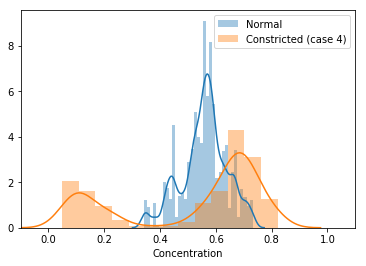

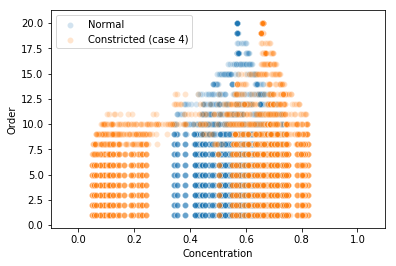

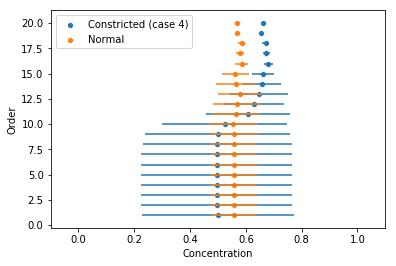

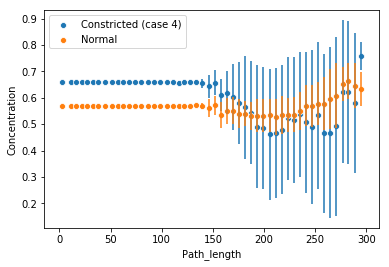

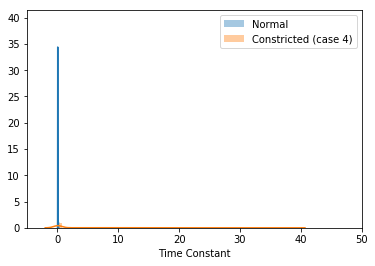

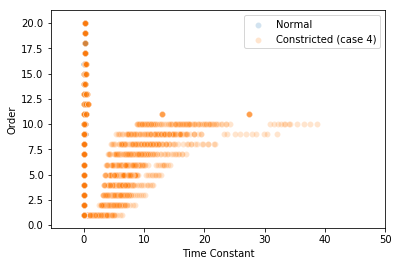

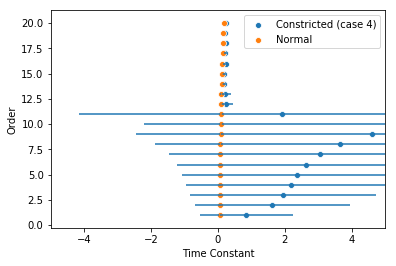

In [32]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Lumped', 'case 4', 20, 'outputs/lumped_case_4', True)

In [33]:
ndfn, ldfn = read_file_data('lumped/Results/P2BRP268-H12816_CAS_LRA_normal.exnode', 'lumped/Geom')
ndfc, ldfc = read_file_data('lumped/Results/P2BRP268-H12816_CAS_LRA_con_6.exnode', 'lumped/Geom')
ldfc.head(5)

,Order,Concentration,Time Constant
0,20,0.575120,0.21623
1,20,0.575117,0.21447
2,20,0.575057,0.21270
3,20,0.575047,0.21094
4,20,0.575032,0.20917


/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


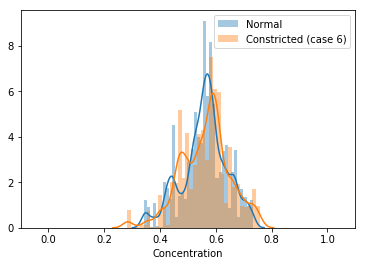

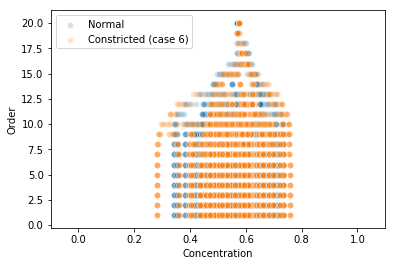

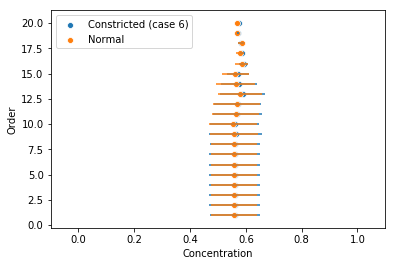

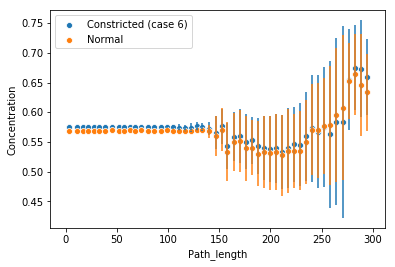

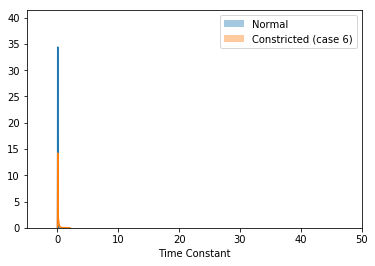

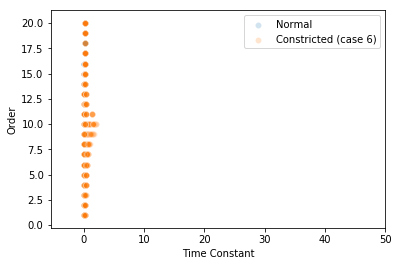

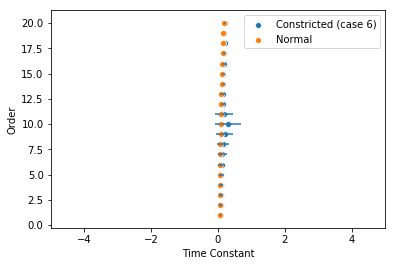

In [34]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Lumped', 'case 6', 20, 'outputs/lumped_case_6', True)

In [35]:
ndfn, ldfn = read_file_data('Asymmetric/Results_end_insp/P2BRP268-H12816_CAS_ARA_normal.exnode', 'Asymmetric/Geom')
ndfc, ldfc = read_file_data('Asymmetric/Results_end_insp/P2BRP268-H12816_CAS_ARA_con_4.exnode', 'Asymmetric/Geom')

/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


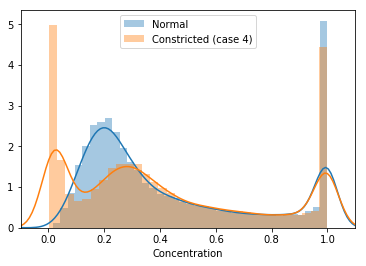

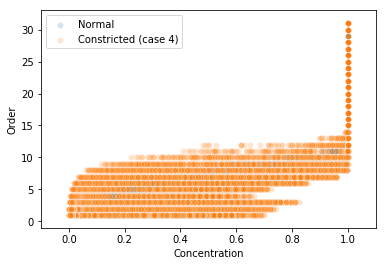

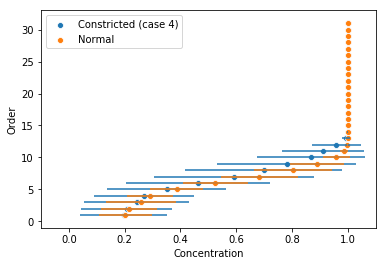

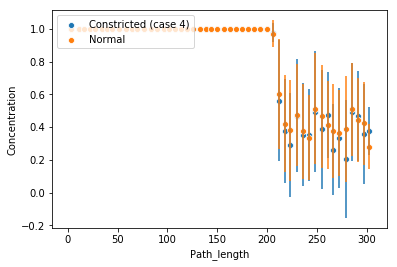

In [36]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Asymmetric_end_insp', 'case 4', 31, 'outputs/Asymmetric_end_insp_case_4')

In [37]:
ndfn, ldfn = read_file_data('Asymmetric/Results_end_insp/P2BRP268-H12816_CAS_ARA_normal.exnode', 'Asymmetric/Geom')
ndfc, ldfc = read_file_data('Asymmetric/Results_end_insp/P2BRP268-H12816_CAS_ARA_con_6.exnode', 'Asymmetric/Geom')

/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


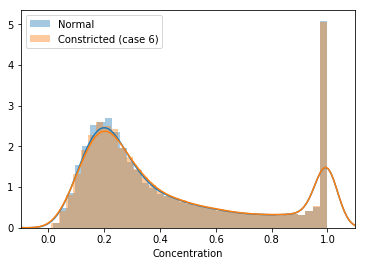

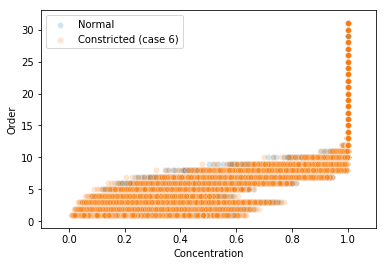

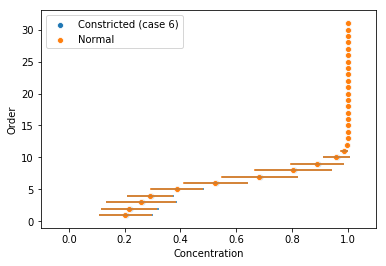

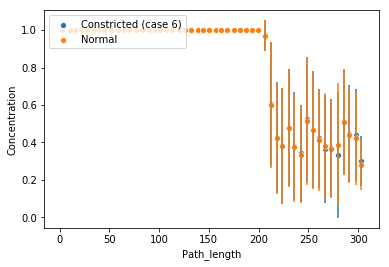

In [38]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Asymmetric_end_insp', 'case 6', 31, 'outputs/Asymmetric_end_insp_case_6')

In [39]:
ndfn, ldfn = read_file_data('Asymmetric/Results_start_exp/P2BRP268-H12816_CAS_ARA_normal.exnode', 'Asymmetric/Geom')
ndfc, ldfc = read_file_data('Asymmetric/Results_start_exp/P2BRP268-H12816_CAS_ARA_con_4.exnode', 'Asymmetric/Geom')

/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


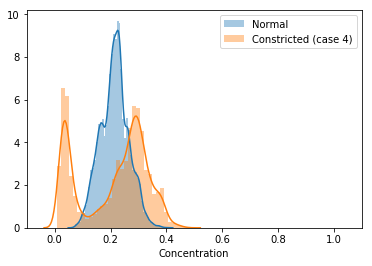

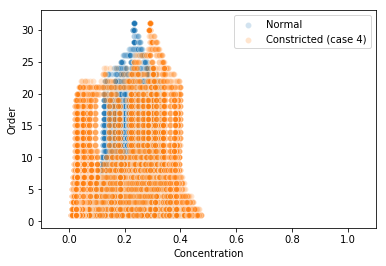

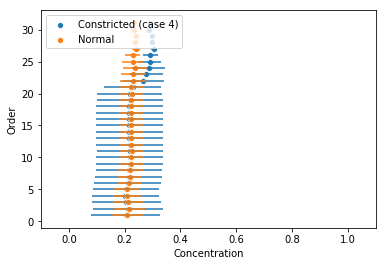

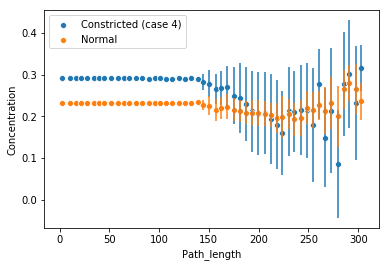

In [40]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Asymmetric_start_exp', 'case 4', 31, 'outputs/Asymmetric_start_exp_case_4')

In [41]:
ndfn, ldfn = read_file_data('Asymmetric/Results_start_exp/P2BRP268-H12816_CAS_ARA_normal.exnode', 'Asymmetric/Geom')
ndfc, ldfc = read_file_data('Asymmetric/Results_start_exp/P2BRP268-H12816_CAS_ARA_con_6.exnode', 'Asymmetric/Geom')

/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/people/aras520/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


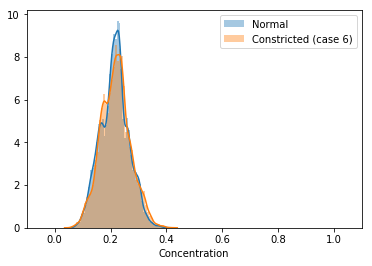

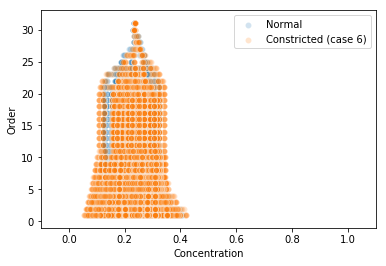

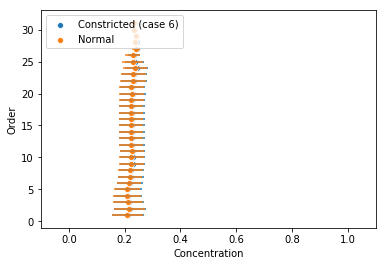

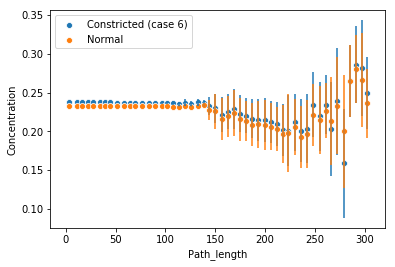

In [42]:
plot_charts(ndfn, ndfc, ldfn, ldfc, 'Asymmetric_start_exp', 'case 6', 31, 'outputs/Asymmetric_start_exp_case_6')